In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from scipy.special import expit
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.formula.api as smfa

In [2]:
from data.utils import make_uniform, make_joint, plot_contour, transform

In [3]:
link = 'https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv'
data = pd.read_csv(link, parse_dates=['Date'])
data.rename(columns={'Damage Incident': 'Damage'}, inplace=True)
data.drop(labels=[3, 24], inplace=True)
data['Damage'] = data['Damage'].astype(int)
data.head(), data.shape

(        Date  Temperature  Damage
 0 1981-04-12           66       0
 1 1981-11-12           70       1
 2 1982-03-22           69       0
 4 1982-01-11           68       0
 5 1983-04-04           67       0,
 (23, 3))

In [4]:
offset = round(data['Temperature'].mean(), 1)
data['x'] = data['Temperature'] - offset
data['y'] = data['Damage']

In [5]:
formula = 'y ~ x'
results = smfa.logit(formula, data=data).fit(disp=False)
results.params

Intercept   -1.115625
x           -0.232163
dtype: float64

In [6]:
inter = results.params['Intercept']
slope = results.params['x']
xs = np.arange(53, 83) - offset
log_odds = inter + slope * xs
#odds = np.exp(log_odds)
#ps = odds / (odds + 1)
ps = expit(log_odds)

In [7]:
log_odds, ps

(array([ 2.7382762 ,  2.50611346,  2.27395072,  2.04178797,  1.80962523,
         1.57746248,  1.34529974,  1.11313699,  0.88097425,  0.64881151,
         0.41664876,  0.18448602, -0.04767673, -0.27983947, -0.51200221,
        -0.74416496, -0.9763277 , -1.20849045, -1.44065319, -1.67281594,
        -1.90497868, -2.13714142, -2.36930417, -2.60146691, -2.83362966,
        -3.0657924 , -3.29795515, -3.53011789, -3.76228063, -3.99444338]),
 array([0.93924781, 0.92456929, 0.90669655, 0.88511521, 0.85931657,
        0.82884484, 0.79336013, 0.75271348, 0.70702407, 0.65674259,
        0.60268105, 0.54599114, 0.48808308, 0.43049313, 0.37472428,
        0.32209405, 0.27362105, 0.22996826, 0.19144422, 0.1580491 ,
        0.12954602, 0.10553894, 0.08554356, 0.06904407, 0.05553372,
        0.04454055, 0.03564141, 0.02846733, 0.02270329, 0.01808462]))

In [8]:
qs_inter = np.linspace(-5, 1, 101)
qs_slope = np.linspace(-0.8, 0.1, 101)
prior_inter = make_uniform(qs_inter, name='Intercept')
prior_slope = make_uniform(qs_slope, name='Slope')
joint_pmf = Pmf(make_joint(prior_inter, prior_slope).stack())
joint_pmf

-0.8  -5.00    0.000098
      -4.94    0.000098
      -4.88    0.000098
      -4.82    0.000098
      -4.76    0.000098
                 ...   
 0.1   0.76    0.000098
       0.82    0.000098
       0.88    0.000098
       0.94    0.000098
       1.00    0.000098
Name: , Length: 10201, dtype: float64

In [9]:
grouped = data.groupby('x')['y'].agg(['count', 'sum'])
grouped

,count,sum
x,,
-16.6,1,1
-12.6,1,1
-11.6,1,1
-6.6,1,1
-3.6,1,0
-2.6,3,0
-1.6,1,0
-0.6,1,0
0.4,4,2


In [10]:
ns = grouped['count']
xs = grouped.index
ps = expit(inter + slope * xs)
ks = grouped['sum']

In [11]:
likes = ss.binom(ns, ps).pmf(ks)
likes.prod()

0.0004653644508250071

In [12]:
likelihood = joint_pmf.copy()
for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    likes = ss.binom(ns, ps).pmf(ks)
    likelihood[slope, inter] = likes.prod()

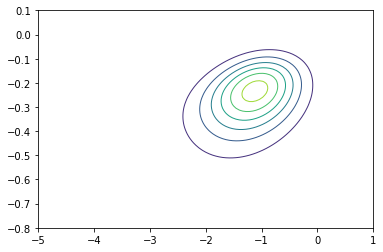

In [13]:
posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()
plot_contour(posterior_pmf.unstack())

<AxesSubplot:>

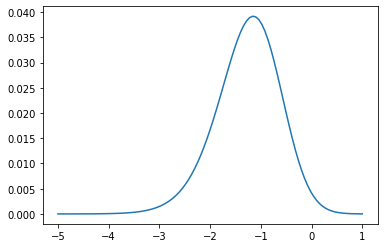

In [24]:
marginal_inter = posterior_pmf.marginal(1)
marginal_inter.plot()

<AxesSubplot:>

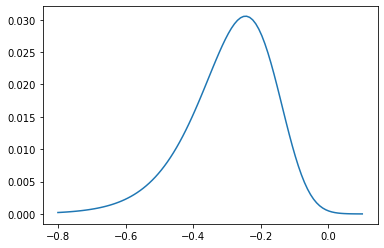

In [25]:
marginal_slope = posterior_pmf.marginal(0)
marginal_slope.plot()

In [26]:
marginal_inter.qs, expit(marginal_inter.qs)

(array([-5.  , -4.94, -4.88, -4.82, -4.76, -4.7 , -4.64, -4.58, -4.52,
        -4.46, -4.4 , -4.34, -4.28, -4.22, -4.16, -4.1 , -4.04, -3.98,
        -3.92, -3.86, -3.8 , -3.74, -3.68, -3.62, -3.56, -3.5 , -3.44,
        -3.38, -3.32, -3.26, -3.2 , -3.14, -3.08, -3.02, -2.96, -2.9 ,
        -2.84, -2.78, -2.72, -2.66, -2.6 , -2.54, -2.48, -2.42, -2.36,
        -2.3 , -2.24, -2.18, -2.12, -2.06, -2.  , -1.94, -1.88, -1.82,
        -1.76, -1.7 , -1.64, -1.58, -1.52, -1.46, -1.4 , -1.34, -1.28,
        -1.22, -1.16, -1.1 , -1.04, -0.98, -0.92, -0.86, -0.8 , -0.74,
        -0.68, -0.62, -0.56, -0.5 , -0.44, -0.38, -0.32, -0.26, -0.2 ,
        -0.14, -0.08, -0.02,  0.04,  0.1 ,  0.16,  0.22,  0.28,  0.34,
         0.4 ,  0.46,  0.52,  0.58,  0.64,  0.7 ,  0.76,  0.82,  0.88,
         0.94,  1.  ]),
 array([0.00669285, 0.00710377, 0.00753973, 0.00800223, 0.00849286,
        0.0090133 , 0.00956532, 0.0101508 , 0.01077173, 0.0114302 ,
        0.01212843, 0.01286876, 0.01365366, 0.01448572, 0.0

array([0.08627419, 0.43536371])

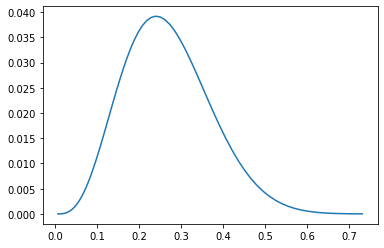

In [29]:
marginal_probs = marginal_inter.transform(expit)
marginal_probs.plot()
marginal_probs.credible_interval(0.9)

array([0.59392632, 0.89852567])

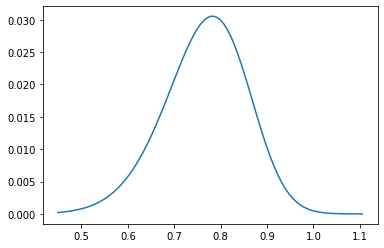

In [30]:
marginal_lr = marginal_slope.transform(np.exp)
marginal_lr.plot()
marginal_lr.credible_interval(0.9)

In [32]:
sample = posterior_pmf.choice(101)

In [33]:
temps = np.arange(31, 83)
xs = temps - offset
xs

array([-38.6, -37.6, -36.6, -35.6, -34.6, -33.6, -32.6, -31.6, -30.6,
       -29.6, -28.6, -27.6, -26.6, -25.6, -24.6, -23.6, -22.6, -21.6,
       -20.6, -19.6, -18.6, -17.6, -16.6, -15.6, -14.6, -13.6, -12.6,
       -11.6, -10.6,  -9.6,  -8.6,  -7.6,  -6.6,  -5.6,  -4.6,  -3.6,
        -2.6,  -1.6,  -0.6,   0.4,   1.4,   2.4,   3.4,   4.4,   5.4,
         6.4,   7.4,   8.4,   9.4,  10.4,  11.4,  12.4])

In [37]:
pred = np.empty((len(sample), len(xs)))
for i, (slope, inter) in enumerate(sample):
    pred[i] = expit(inter + slope * xs)

In [39]:
pred

array([[0.99999935, 0.99999901, 0.99999851, ..., 0.00248449, 0.00164528,
        0.00108922],
       [0.99998799, 0.99998296, 0.99997582, ..., 0.00295882, 0.00208687,
        0.0014715 ],
       [0.99958483, 0.99948064, 0.99935033, ..., 0.03955897, 0.03187312,
        0.02564068],
       ...,
       [0.99906273, 0.99884857, 0.99858555, ..., 0.04219268, 0.03460965,
        0.02834914],
       [0.99725329, 0.99677503, 0.9962138 , ..., 0.11979214, 0.10382769,
        0.0897738 ],
       [0.9706194 , 0.96712451, 0.96322965, ..., 0.10097844, 0.09092439,
        0.08178032]])

In [42]:
low, median, high = np.percentile(pred, [5, 50, 95], axis=0)
low

array([9.82450078e-01, 9.79639741e-01, 9.76167872e-01, 9.72120822e-01,
       9.67860433e-01, 9.63736284e-01, 9.59105284e-01, 9.53911173e-01,
       9.48093052e-01, 9.41585444e-01, 9.34318495e-01, 9.26218353e-01,
       9.17207785e-01, 9.07207047e-01, 8.96135084e-01, 8.83911078e-01,
       8.70456381e-01, 8.55696866e-01, 8.39565670e-01, 8.19889644e-01,
       7.94880654e-01, 7.67384303e-01, 7.43759257e-01, 7.09550099e-01,
       6.71196140e-01, 6.45107032e-01, 6.18125620e-01, 5.90395357e-01,
       5.54532222e-01, 5.00999999e-01, 4.61426798e-01, 4.19993518e-01,
       3.72899002e-01, 3.28098034e-01, 2.87942061e-01, 2.47721774e-01,
       2.10153568e-01, 1.61921517e-01, 1.26573590e-01, 9.45930933e-02,
       7.01230963e-02, 4.93785410e-02, 3.20898339e-02, 2.14656901e-02,
       1.35891670e-02, 8.54692543e-03, 5.47213101e-03, 3.43738830e-03,
       2.10024253e-03, 1.28257770e-03, 7.82995740e-04, 4.77914826e-04])

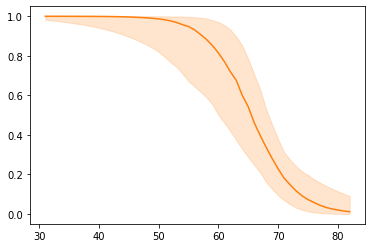

In [43]:
plt.fill_between(temps, low, high, color='C1', alpha=0.2)
plt.plot(temps, median, color='C1', label='logistic model')